In [1]:
%%bash
python3 -m pip install -U scikit-learn


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
import matplotlib.pyplot as plt
from math import ceil, floor, log

SMALL = False

if SMALL:
    plt.rc('font', size=20) # extended abstract
    fig_size = (7,4)
else:
    plt.rc('font', size=16) # main paper
    fig_size = (8,5)


In [3]:
def change_order(x, l, target=None):
    order = 0
    max_order = len(l) - 1
    
    if target is None:
        while abs(x) >= l[order][1] and order < max_order:
            x /= l[order][1]
            order += 1
    else:
        while order < target and order < max_order:
            x /= l[order][1]
            order += 1
    
    return x, order

MEM_SUFFIX = [
    ('B', 1024),
    ('KiB', 1024),
    ('MiB', 1024),
    ('GiB', 1024),
    ('TiB', 1024),
]

TIME_SUFFIX = [
    ('ms', 1000),
    ('s', 60),
    ('min', 60),
    ('h', 24),
    ('day(s)', 0)
]

def h(x, target=None, precision=2, include_prefix=True):
    """Translates a number of bytes to a human-readable string."""    
    x, order = change_order(x, MEM_SUFFIX, target)
    suffix = MEM_SUFFIX[order][0]

    if include_prefix:
        return f"{x:.{precision}f}{suffix}"
    
    return f"{x:.{precision}f}"

def hs(x, target=None, precision=2, include_prefix=True):
    """Translates a number of ms to a human-readable string."""
    x, order = change_order(x, TIME_SUFFIX, target)
    suffix = TIME_SUFFIX[order][0]

    if include_prefix:
        return f"{x:.{precision}f}{suffix}"
    
    return f"{x:.{precision}f}"

def memory_x_axis(axs, max_order=None, precision=2):
    xmax = axs.axis()[1]
    if max_order is None:
        _, max_order = change_order(xmax, MEM_SUFFIX)

    axs.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda v, _: h(v, max_order, precision, not SMALL)))
    
    per_tick = pow(2, floor(log(xmax / 4)/log(2)))
    axs.set_xticks(np.arange(0, xmax + 1, per_tick))
    
    if SMALL:
        xlbl = axs.xaxis.get_label().get_text()
        axs.set_xlabel(xlbl + " (" + MEM_SUFFIX[max_order][0] + ")")
    
def memory_y_axis(axs, max_order=None, precision=0):
    ymin = axs.axis()[2]
    ymax = axs.axis()[3]
    if max_order is None:
        _, max_order = change_order(ymax, MEM_SUFFIX)
    
    axs.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda v, _: h(v, max_order, precision, not SMALL)))
    
    per_tick = pow(2, floor(log(ymax / 4)/log(2)))
    axs.set_yticks(np.arange(ymin, ymax + 1, per_tick))
    
    if SMALL:
        ylbl = axs.yaxis.get_label().get_text()
        axs.set_ylabel(ylbl + " (" + MEM_SUFFIX[max_order][0] + ")")

def mseconds_x_axis(axs, max_order=None, precision=2, nr_mins=1):
    if max_order is None:
        xmax = axs.axis()[1]
        _, max_order = change_order(xmax, TIME_SUFFIX)
    
    axs.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda v, _: hs(v, max_order, precision, not SMALL)))
    
    xmin = axs.axis()[0]
    xmax = axs.axis()[1]
    axs.set_xticks(np.arange(nr_mins * 60000 * round(xmin/ 60000 / nr_mins), xmax, nr_mins * 60000))
    
    if SMALL:
        xlbl = axs.xaxis.get_label().get_text()
        axs.set_xlabel(xlbl + " (" + TIME_SUFFIX[max_order][0] + ")")

def mseconds_y_axis(axs, max_order=None, precision=2):
    if max_order is None:
        ymax = axs.axis()[3]
        _, max_order = change_order(ymax, TIME_SUFFIX)
    
    axs.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda v, _: hs(v, max_order, precision, not SMALL)))
    
    if SMALL:
        ylbl = axs.yaxis.get_label().get_text()
        axs.set_ylabel(ylbl + " (" + TIME_SUFFIX[max_order][0] + ")")

In [4]:
def extractFloat(num):
    try:
        return float(num)
    except ValueError:
        return extractFloat(num[0])

def convert_to_array(x):
    if isinstance(x, pd.DataFrame) or isinstance(x, pd.Series):
        return x.values
    if isinstance(x, list):
        return np.array(x)
    return x

def train_reg(x, y, fit_intercept=True, x_pos_means_y_pos=True):
    xv, yv = convert_to_array(x), convert_to_array(y)
    xv, yv = xv.reshape(-1, 1), yv.reshape(-1)
    
    regr = linear_model.HuberRegressor(fit_intercept=fit_intercept, epsilon=1.01, alpha=1e-9, max_iter=1000)
    regr.fit(xv, yv)
    
    if x_pos_means_y_pos and extractFloat(regr.intercept_) < 0:
        return train_reg(x, y, False)
    
    prediction = regr.predict(xv)
    
    MSEY = np.sum((prediction - yv)**2)
    MSEX = np.sum((xv - np.mean(xv))**2)
    
    regr.slope_std = np.sqrt(
        MSEY / (len(xv)-2) *
        1 / MSEX
    )
    
    regr.intercept_std = np.sqrt(
        MSEY / (len(xv)-2) *
        (
            1/len(xv) +
            np.mean(xv)**2 / MSEX
        )
    )
    
    def pred_std(x):
        return np.sqrt(
            MSEY / (len(xv)-2) *
            (
                1 +
                1/len(xv) +
                (x - np.mean(xv))**2 / MSEX
            )
        )
    
    regr.pred_std = pred_std

    return regr

def eval_reg(reg, x):
    if isinstance(x, pd.Series):
        return pd.Series(reg.predict(x.values.reshape(-1, 1))[:], index=x.values)
    if isinstance(x, list):
        return reg.predict(np.array([x]))
    if isinstance(x, int):
        return reg.predict(np.array([[x]]))[0]
    return reg.predict(x)

In [5]:
def load_dataset(*directories):
    results = []
    time_results = []

    for directory in directories:
        for file in os.listdir(directory):
            file_path = os.path.join(directory, file)

            df = pd.read_csv(file_path, decimal=",", delimiter=";")
            df["dataset"] = file_path

            if "_time" in file:
                time_results.append(df)
            else:
                results.append(df)

    df_results = pd.concat(results)
    
    def resample(df):
        df = df.set_index("time").drop(columns=["dataset"])
        new_index = pd.date_range(df.index.min().ceil('1S'), df.index.max(), freq='1S') # calculate ideal index
        df = (
            df
            .reindex(df.index.union(new_index)) # add new index values to exising index
            .interpolate(method='nearest') # interpolate to new values
            .reindex(new_index) # remove old index
            .reset_index() # reset index
            .rename(columns={"index": "time"})
        )
        return df

    df_results.loc[:,'time'] = pd.to_datetime(df_results.time, unit='s')
    df_results = df_results.groupby("dataset").apply(resample)
    df_results.index.names = ["dataset", "DROP"]
    df_results = df_results.reset_index().drop(columns=["DROP"])
    
    df_results["containerd_mem"] -= 65058282.68437986
    df_results["containerd_limit"] -= 65058282.68437986
    df_results["mem_usage"] = df_results.app_mem + df_results.containerd_mem + df_results.pause_mem
    
    df_time_results = pd.concat(time_results)
    
    active_ranges = (
        pd.to_datetime(df_time_results.starttime, unit="ns")
        .groupby(df_time_results.dataset)
        .apply(lambda x: (
            x.tail(175).min(),
            x.tail(175).max()
        ))
        .to_dict()
    )
    
    def categorize(df):
        active_min, active_max = active_ranges[(
            df.dataset.values[0]
            .replace(".csv", "_time.csv")
            .replace("_uninst_time", "_time_uninst")
        )]
        
        df.loc[df.time < active_min, "category"] = "startup"
        df.loc[df.time > active_min, "category"] = "active"
        df.loc[df.time > active_max, "category"] = "idle"
        
        df.time -= df.time.min()
        df.time /= np.timedelta64(1,'ms')
        return df
    
    df_results = df_results.groupby("dataset").apply(categorize)
    
    return df_results, df_time_results

In [6]:
df_results, df_time_results = load_dataset(
    "test_results_run1",
    "test_results_run2",
    "test_results_run3",
    "test_results_run4",
    "test_results_run5",
)

In [7]:
def df_result_regions(df):
    active_end = (df.category == "idle").values.argmax()
    idle_end = len(df) - 1
    
    size = 100
    
    if "wasm" in df.dataset.values[0]:
        size = 300
    
    return (
        (active_end - 101, active_end),
        (idle_end - size - 1, idle_end),
    )

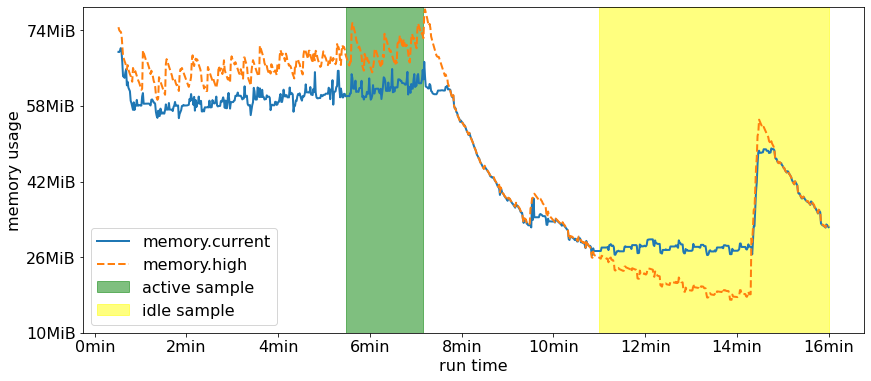

In [8]:
def plot_dataset(dataset):
    fig, axs = plt.subplots(figsize=(14,6))

    df = df_results[df_results.dataset == dataset].copy()

    df["time"] -= df.time.min()
    df["total_mem"] = df.app_mem + df.pause_mem + df.containerd_mem
    df["total_max"] = df.app_limit + df.pause_mem + df.containerd_mem
    
    MIB = 1024*1024

    yrange = (MIB * 10, MIB * ceil(df["total_max"].iloc[31:].max() / MIB))

    df.iloc[31: , :].plot(
        x="time",
        y="total_mem",
        style='-',
        linewidth=2,
        ax=axs,
        ylim=yrange,
        label="memory.current"
    )
    df.iloc[31: , :].plot(
        x="time",
        y="total_max",
        style='--',
        linewidth=2,
        ax=axs,
        label="memory.high"
    )

    (reg1s, reg1e), (reg2s, reg2e) = df_result_regions(df)
    r1 = axs.axvspan(
        df.iloc[reg1s].time,
        df.iloc[reg1e].time,
        alpha=0.5, color='green',
        label="active"
    )
    r2 = axs.axvspan(
        df.iloc[reg2s].time,
        df.iloc[reg2e].time,
        alpha=0.5, color='yellow',
        label="idle"
    )

    handles, _ = axs.get_legend_handles_labels()
    memory_current, memory_high = handles[:2]
    axs.legend([
        memory_current, memory_high, r1, r2
    ], [
        'memory.current', 'memory.high',
        'active sample', 'idle sample'
    ])

    axs.set_ylabel("memory usage")
    axs.set_xlabel("run time")

    memory_y_axis(axs, 2)
    mseconds_x_axis(axs, 2, 0, nr_mins=2)

plot_dataset("test_results_run4/out_wasm_10_uninst.csv")
plt.savefig('./images/01_example_run.png', bbox_inches='tight')

In [9]:
def extract_name(name):
    name = os.path.basename(os.path.normpath(name))
    
    if name[0].isdigit():
        index = name.index('_')
        count, typ, variant, _ = extract_name(name[index+1:])
        return count, typ, variant, int(name[:index])

    suffix = (
        name
        .strip('out_')
        .strip('golang_')
        .strip('rust_')
        .strip('comb_')
        .strip('wasm_')
        .strip('.csv')
        .strip('_time')
    )
    
    parts = suffix.split('_')
    
    count = int(parts[0])
    variant = "NONE"
    if len(parts) > 1:
        variant = parts[-1]
        
    if "wasm" in name:
        return count, "wasm", variant, 0
    if "golang" in name:
        return count, "golang", variant, 0
    if "rust" in name:
        return count, "rust", variant, 0
    if "comb" in name:
        return count, "comb", variant, 0

In [10]:
def load_intervals(df_results, df_time_results):
    def load_intervals_activity(selector_id, activity):
        def resample(df):
            start, end = df_result_regions(df)[selector_id]
            return df.iloc[start:end]

        df = df_results.groupby("dataset").apply(resample)
        # df.index.names = ["dataset", "dataset_id"]
        df = df.reset_index(drop=True)
        df.loc[:, "activity"] = activity
        return df

    def add_metadata(df):
        return pd.concat([
            df,
            pd.DataFrame(
                df["dataset"].apply(extract_name).tolist(),
                columns=['workers', 'type', 'variant', 'heap_mem'],
                index=df.index
            )
        ], axis=1)

    df_results = pd.concat([
        load_intervals_activity(0, "active"),
        load_intervals_activity(1, "idle"),
    ])
    df_results = add_metadata(df_results)

    df_time_results = df_time_results.groupby("dataset").apply(lambda df: df.tail(175))
    df_time_results = df_time_results.reset_index(drop=True)
    df_time_results = add_metadata(df_time_results)
    
    return (
        df_results[df_results.activity == "active"],
        df_results[df_results.activity == "idle"],
        df_time_results
    )

In [11]:
def load_means(df_active, df_idle, df_time):
    def calc_metrics(df):
         return {
            "app_mem": df.app_mem.mean(),
            "containerd_mem": df.containerd_mem.mean(),
            "pause_mem": df.pause_mem.mean(),
            
            "mem_q025": df.mem_usage.quantile(0.025),
            "mem_q50": df.mem_usage.quantile(0.500),
            "mem_q975": df.mem_usage.quantile(0.975),
             
            "mem_mean": df.mem_usage.mean(),
            "mem_std": df.mem_usage.std(),
        }

    active_mem_means = {}
    for group_id, df in df_active.groupby(["workers", "type", "variant", "heap_mem"]):
        active_mem_means[group_id] = calc_metrics(df)

    idle_mem_means = {}
    for group_id, df in df_idle.groupby(["workers", "type", "variant", "heap_mem"]):
        idle_mem_means[group_id] = calc_metrics(df)

    time_means = {}
    for name, df in df_time.groupby("dataset"):
        time_means[extract_name(name)] = {            
            "roundtime_q025": df.roundtime.quantile(0.025),
            "roundtime_q50": df.roundtime.quantile(0.500),
            "roundtime_q975": df.roundtime.quantile(0.975),
            
            "roundtime_mean": df.roundtime.mean(),
            "roundtime_std": df.roundtime.std(),
        }
        
    idxcolumns = ['workers', 'type', 'variant', 'heap_mem']
    memcolumns = [
        'app_mem', 'containerd_mem', 'pause_mem',
        'mem_q025', 'mem_q50', 'mem_q975',
        'mem_mean', 'mem_std',
    ]
    timecolumns = [
        'roundtime_q025', 'roundtime_q50', 'roundtime_q975',
        'roundtime_mean', 'roundtime_std',
    ]

    df_active_means = pd.DataFrame(active_mem_means).T.reset_index()
    df_active_means.columns = idxcolumns + memcolumns
    df_active_means = df_active_means.set_index("workers", drop=False).sort_index()

    df_idle_means = pd.DataFrame(idle_mem_means).T.reset_index()
    df_idle_means.columns = idxcolumns + memcolumns
    df_idle_means = df_idle_means.set_index("workers", drop=False).sort_index()

    df_time_means = pd.DataFrame(time_means).T.reset_index()
    df_time_means.columns = idxcolumns + timecolumns
    df_time_means = df_time_means.set_index("workers", drop=False).sort_index()
    
    return df_active_means, df_idle_means, df_time_means

In [12]:
df_active, df_idle, df_time = load_intervals(*load_dataset(    
    "test_results_run1",
    "test_results_run2",
    "test_results_run3",
    "test_results_run4",
    "test_results_run5",
))
df_active_means, df_idle_means, df_time_means = load_means(df_active, df_idle, df_time)

df_heap_active, df_heap_idle, df_heap_time = load_intervals(*load_dataset(
    "test_heap_results_run1",
    "test_heap_results_run2",
    "test_heap_results_run3",
    "test_heap_results_run4",
    "test_heap_results_run5",
))

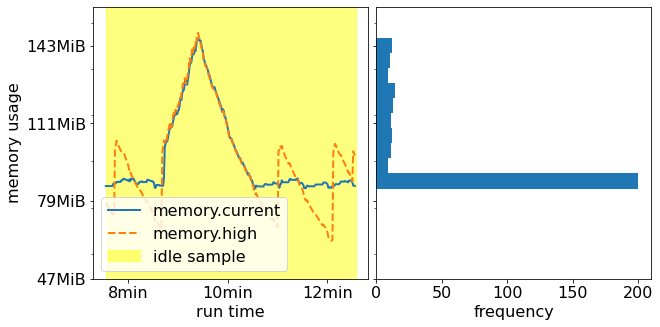

In [13]:
fig, (axs, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True)

df = df_results[df_results.dataset == "test_results_run2/out_wasm_70.csv"].copy()

df["time"] -= df.time.min()
df["total_mem"] = df.app_mem + df.pause_mem + df.containerd_mem
df["total_max"] = df.app_limit + df.pause_mem + df.containerd_mem

MIB = 1024*1024

yrange = (47.0 * MIB, 159.0 * MIB)

(reg1s, reg1e), (reg2s, reg2e) = df_result_regions(df)
df.iloc[reg2s:reg2e , :].plot(
    x="time",
    y="total_mem",
    style='-',
    linewidth=2,
    ax=axs,
    ylim=yrange,
    label="memory.current"
)
df.iloc[reg2s:reg2e , :].plot(
    x="time",
    y="total_max",
    style='--',
    linewidth=2,
    ax=axs,
    ylim=yrange,
    label="memory.high"
)
r2 = axs.axvspan(
    df.iloc[reg2s].time,
    df.iloc[reg2e].time,
    alpha=0.5, color='yellow',
    label="idle"
)

handles, _ = axs.get_legend_handles_labels()
memory_current, memory_high = handles[:2]
axs.legend([
    memory_current, memory_high, r2
], [
    'memory.current', 'memory.high', 'idle sample'
])

axs.set_ylabel("memory usage")
axs.set_xlabel("run time")

memory_y_axis(axs)
mseconds_x_axis(axs, 2, 0, nr_mins=2)

df_idle[df_idle.dataset == "test_results_run2/out_wasm_70.csv"].mem_usage.hist(bins=10, ax=ax2, orientation="horizontal")
ax2.grid(False)

ax2.set_xlabel("frequency")

plt.subplots_adjust(wspace=0.03)

plt.savefig('./images/01_example_hist.png', bbox_inches='tight')

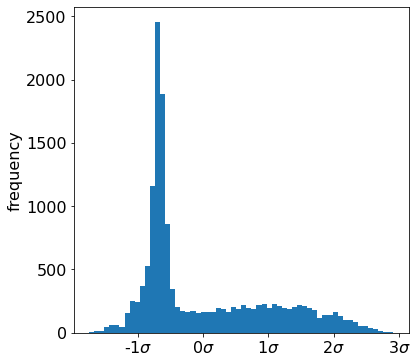

In [14]:
fig, axs = plt.subplots(figsize=(6,6))

(
    df_idle[(df_idle.type == "wasm") & (df_idle.variant == "NONE")]
    .groupby("dataset")
    .apply(lambda x: (x.mem_usage - x.mem_usage.mean()) / x.mem_usage.std())
    .reset_index(drop=True)
).hist(bins=60, ax=axs) # , orientation="horizontal")

axs.grid(False)

axs.set_ylabel("frequency")

axs.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: str(int(x)) + r"$\sigma$"))

plt.savefig('./images/01_full_hist.png', bbox_inches='tight')

In [15]:
color_palette = sns.color_palette("colorblind")
color_idx = -1
color_d = {}
    
def newCol():
    global color_palette
    global color_idx
    global color_d

    def col(row):
        global color_d
        # nonlocal d
        # name = getattr(row, 'index', None)
        name = row
        
        if name is None or name not in color_d:
            global color_idx
            # nonlocal idx
            color_idx += 1
            color_d[name] = np.array([color_palette[color_idx]])
        
        return color_d[name]
    
    return col

In [16]:
def compare_maxes(maxs, a, b, increase=False):
    if increase:
        vals = (
            (max(maxs[a]) / min(maxs[b])) - 1, # best:  a_min / b_max
            (min(maxs[a]) / max(maxs[b])) - 1  # worst: a_max / b_min
        )
    else:
        vals = (
            1 - (max(maxs[a]) / min(maxs[b])), # worst: a_max / b_min
            1 - (min(maxs[a]) / max(maxs[b]))  # best : a_min / b_max  
        )
    
    mean = (vals[0] + vals[1]) / 2
    diff = abs(vals[0] - mean)
    
    return f"{mean*100:.2f}\% \pm{diff*100:.2f}\%"

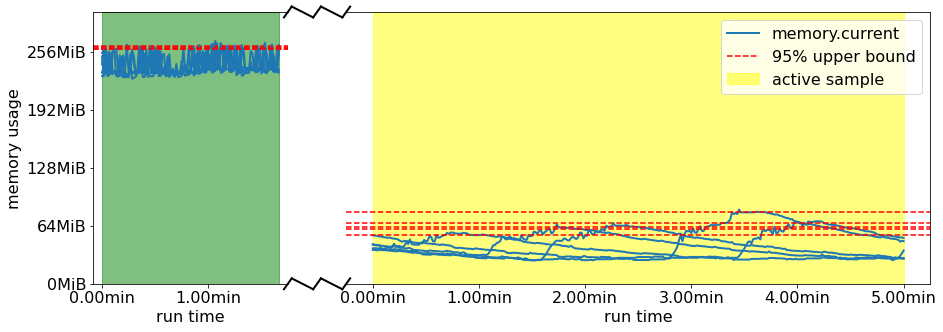

In [17]:
from matplotlib import gridspec

# fig = plt.figure()

# fig.set_figheight(6)
# fig.set_figwidth(14)
 
# create grid for different subplots
# spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[100, 300], wspace=0.15)

# ax1 = fig.add_subplot(spec[0])
# ax2 = fig.add_subplot(spec[1], sharey=ax1)

fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [100,300]}, figsize=(15,5), sharey=True)
plt.subplots_adjust(wspace=0.15)

MIB = 1024*1024
yrange = (0, 300.0 * MIB)
nr_operators = 60

for group_id, group_df in df_active[
    (df_active.category == "active") &
    (df_active.workers == nr_operators) &
    (df_active.type == "wasm") &
    (df_active.variant == "unins")
].groupby(["type", "variant"]):
    col = newCol()
    for dataset, df in group_df.groupby(["dataset"]):
        df.time -= df.time.min()

        df.plot(
            x="time",
            y="mem_usage",
            style='-',
            linewidth=2,
            ax=ax1,
            ylim=yrange,
            label="memory.current",
            legend=False,
            color="tab:blue",
        )

        ax1.axhline(y=df.mem_usage.quantile(0.95), color='r', linestyle='--')

    r2 = ax1.axvspan(
        df.iloc[0].time,
        df.iloc[-1].time,
        alpha=0.5,
        color='green',
        label="idle",
        figure=fig
    )

    memory_y_axis(ax1)
    mseconds_x_axis(ax1)
    
    # ax1.xaxis.set_tick_params(rotation=-20)

    ax1.set_ylabel("memory usage")
    ax1.set_xlabel("run time")
    
for group_id, group_df in df_idle[
    (df_idle.category == "idle") &
    (df_idle.workers == nr_operators) &
    (df_idle.type == "wasm") &
    (df_idle.variant == "unins")
].groupby(["type", "variant"]):
    col = newCol()
    for dataset, df in group_df.groupby(["dataset"]):
        df.time -= df.time.min()

        df.plot(
            x="time",
            y="mem_usage",
            style='-',
            linewidth=2,
            ax=ax2,
            ylim=yrange,
            label="memory.current",
            color="tab:blue",
        )

        r1 = ax2.axhline(y=df.mem_usage.quantile(0.95), color='r', linestyle='--')

    r2 = ax2.axvspan(
        df.iloc[0].time,
        df.iloc[-1].time,
        alpha=0.5,
        color='yellow',
        label="idle"
    )

    handles, _ = ax2.get_legend_handles_labels()
    memory_current = handles[0]
    ax2.legend([
        memory_current, r1, r2
    ], [
        'memory.current', '95% upper bound', 'active sample'
    ])

    # ax2.xaxis.set_tick_params(rotation=-20)
    
    memory_y_axis(ax2)
    mseconds_x_axis(ax2)

    ax2.set_ylabel("memory usage")
    ax2.set_xlabel("run time")

d = .020

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

kwargs = dict(transform=ax1.transAxes, linewidth=2, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (0-d, 0+d), **kwargs)
ax1.plot((1 - d, 1 + d), (1-d, 1+d), **kwargs)

ax1.plot((1.15 - d, 1 + d), (0-d, 0+d), **kwargs)
ax1.plot((1.15 - d, 1 + d), (1-d, 1+d), **kwargs)

ax1.plot((1.30 - d, 1.15 + d), (0-d, 0+d), **kwargs)
ax1.plot((1.30 - d, 1.15 + d), (1-d, 1+d), **kwargs)

ax1.plot((1.15 - d, 1.15 + d), (0-d, 0+d), **kwargs)
ax1.plot((1.15 - d, 1.15 + d), (1-d, 1+d), **kwargs)

kwargs = dict(transform=ax2.transAxes, linewidth=2, color='k', clip_on=False)
ax2.plot((0 - d/ 3, 0 + d/ 3), (0-d, 0+d), **kwargs)
ax2.plot((0 - d/ 3, 0 + d/ 3), (1-d, 1+d), **kwargs)

ax2.get_yaxis().set_visible(False)

plt.minorticks_off()

plt.savefig('./images/01_upper_bounds.png', bbox_inches='tight')

In [18]:
color_palette = sns.color_palette("colorblind")
color_idx = -1
color_d = {}

1473074278.4879544
645466727.8033174
237656651.06843865
rust vs golang: 56.06\% \pm2.50\%
wasm vs golang: 83.81\% \pm1.12\%
wasm vs rust: 63.17\% \pm1.18\%


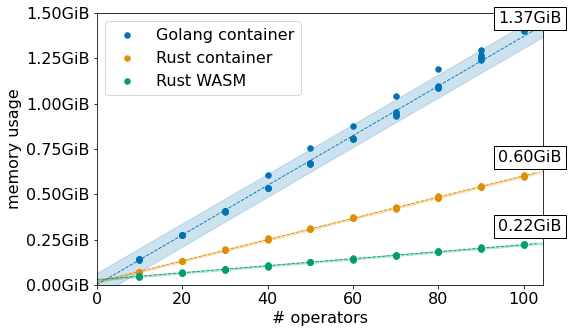

In [19]:
fig, axs = plt.subplots(figsize=fig_size)

activ_maxs = {}
col = newCol()
for group_id, group_df in df_active.groupby(["type", "variant"]):
    if group_id[1] != "NONE" or group_id[0] == "comb":
        continue

    mean_df = group_df.groupby("dataset")[["workers", "mem_usage"]].quantile(0.95)
    std_df = group_df.groupby("dataset").mem_usage.std()
    std_df.name = "mem_usage_std"
    group_df = pd.concat([mean_df, std_df], axis=1)
    
    opts = dict(
        x="workers",
        y="mem_usage",
        xlim=(0, None),
        ylim=(0, 1.5*1024*1024*1024 + 1),
        ax=axs,
        c=col(group_id),
        label={
            "golang": "Golang container",
            "rust": "Rust container",
            "wasm": "Rust WASM"
        }[group_id[0]]
    )
    
    group_df.plot(kind="scatter", s=30, **opts)
    
    reg = train_reg(group_df.workers, group_df.mem_usage)
    
    prediction = eval_reg(reg, pd.Series([*np.arange(0, 101, 10), 103]))
    
    prediction.plot(style="--", linewidth=0.9, **opts)
    
    max_mem = prediction[100]
    print(max_mem)
    plt.text(94, max_mem + 60 * MIB, h(max_mem, 3), va='bottom', bbox=dict(facecolor='white'))
    activ_maxs[group_id] = (max_mem - 1.96 * reg.pred_std(100), max_mem + 1.96 * reg.pred_std(100))
    
    x_values = np.arange(0, 110, 1)
    y_values = eval_reg(reg, x_values.reshape(-1, 1))
    y_std = np.array([1.96 * reg.pred_std(x) for x in x_values])

    plt.fill_between(x_values, y_values-y_std, y_values+y_std, alpha=0.2, color=col(group_id))

    """
    plt.errorbar(
        group_df.workers,
        group_df.mem_usage,
        yerr=1.96 * group_df.mem_usage_std,
        fmt=' ',
        capsize=3,
        elinewidth=1,
        capthick=1,
        color=col(group_id),
    )
    """
    
axs.set_ylabel("memory usage")
axs.set_xlabel("# operators")

memory_y_axis(axs, precision=2)

plt.savefig('./images/02_languages_active.png', bbox_inches='tight')

print("rust vs golang: " + compare_maxes(activ_maxs, ('rust', 'NONE'), ('golang', 'NONE')))
print("wasm vs golang: " + compare_maxes(activ_maxs, ('wasm', 'NONE'), ('golang', 'NONE')))

print("wasm vs rust: " + compare_maxes(activ_maxs, ('wasm', 'NONE'), ('rust', 'NONE')))

1186297103.638142
615709212.4013808
193531941.69338876
rust vs golang: 48.04\% \pm1.93\%
wasm vs golang: 83.65\% \pm1.41\%


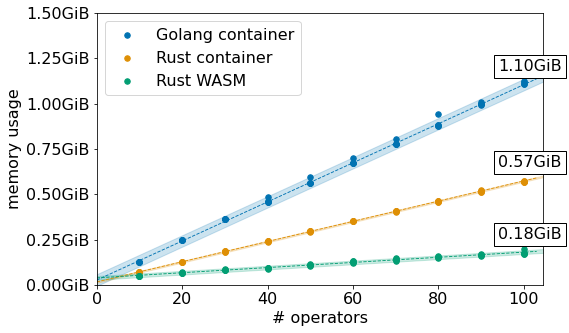

In [20]:
_, axs = plt.subplots(figsize=fig_size)

idle_maxs = {}
col = newCol()
for group_id, group_df in df_idle.groupby(["type", "variant"]):
    if group_id[1] != "NONE" or group_id[0] == "comb":
        continue
    
    mean_df = group_df.groupby("dataset")[["workers", "mem_usage"]].quantile(0.95)
    std_df = group_df.groupby("dataset").mem_usage.std()
    std_df.name = "mem_usage_std"
    group_df = pd.concat([mean_df, std_df], axis=1)
    
    opts = dict(
        x="workers",
        y="mem_usage",
        xlim=(0, None),
        ylim=(0, 1.5*1024*1024*1024 + 1),
        ax=axs,
        c=col(group_id),
        label={
            "golang": "Golang container",
            "rust": "Rust container",
            "wasm": "Rust WASM"
        }[group_id[0]]
    )
    
    group_df.plot(kind="scatter", s=30, **opts)
    
    reg = train_reg(group_df.workers, group_df.mem_usage)
    
    prediction = eval_reg(reg, pd.Series([*np.arange(0, 101, 10), 103]))
    
    prediction.plot(style="--", linewidth=0.9, **opts)
    
    max_mem = prediction[100]
    print(max_mem)
    plt.text(94, max_mem + 60 * MIB, h(max_mem, 3), va='bottom', bbox=dict(facecolor='white'))
    idle_maxs[group_id] = (max_mem - 1.96 * reg.pred_std(100), max_mem + 1.96 * reg.pred_std(100))
    
    x_values = np.arange(0, 110, 1)
    y_values = eval_reg(reg, x_values.reshape(-1, 1))
    y_std = np.array([1.96 * reg.pred_std(x) for x in x_values])

    plt.fill_between(x_values, y_values-y_std, y_values+y_std, alpha=0.2, color=col(group_id))
    
    """
    plt.errorbar(
        group_df.workers,
        group_df.mem_usage,
        yerr=1.96 * group_df.mem_usage_std,
        fmt=' ',
        capsize=3,
        elinewidth=2,
        capthick=2,
        color=col(group_id),
    )
    """

axs.set_ylabel("memory usage")
axs.set_xlabel("# operators")

memory_y_axis(axs, precision=2)

plt.savefig('./images/02_languages_idle.png', bbox_inches='tight')

print("rust vs golang: " + compare_maxes(idle_maxs, ('rust', 'NONE'), ('golang', 'NONE')))
print("wasm vs golang: " + compare_maxes(idle_maxs, ('wasm', 'NONE'), ('golang', 'NONE')))

In [21]:
idle_reductions = {
    k: 1 - (sum(idle_maxs[k]) / sum(activ_maxs[k]))
    for k in idle_maxs.keys()
}

idle_reduction_avg = sum(idle_reductions.values()) / 3

for k, v in idle_reductions.items():
    print(f"idle reduction {k}: {v*100:.2f}\%")

print(f"average: {idle_reduction_avg*100:.2f}\%")

idle reduction ('golang', 'NONE'): 19.47\%
idle reduction ('rust', 'NONE'): 4.61\%
idle reduction ('wasm', 'NONE'): 18.57\%
average: 14.21\%


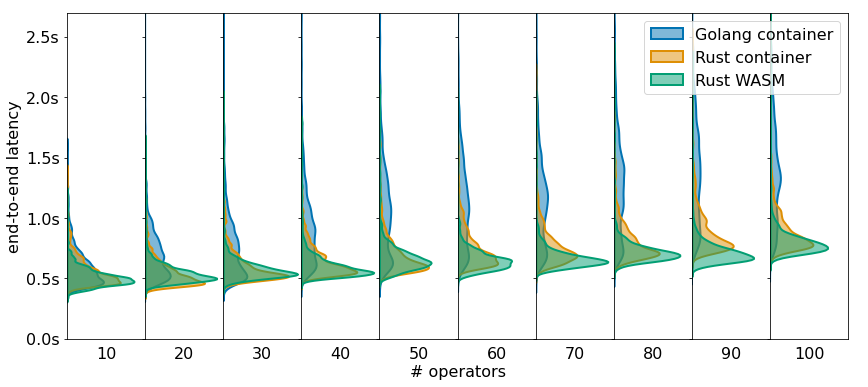

In [22]:
fig, axs = plt.subplots(1, 10, figsize=(14,6), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0)

col = newCol()
for group_id, group_df in df_time.groupby(["workers", "type", "variant"]):
    if group_id[1] == "comb" or group_id[2] != "NONE":
        continue

    index = int(group_id[0] / 10 - 1)

    sns.kdeplot(
        data=group_df,
        y="roundtime",
        legend=False,
        ax=axs[index],
        fill=True,
        alpha=0.5,
        linewidth=2,
        bw_adjust=0.5,
        color=col((group_id[1], group_id[2]))
    )
    
    # if group_id[0] == 100:
    #     mean = group_df.roundtime.mean()
    #     plt.text(0.006, mean, hs(mean), va='bottom', bbox=dict(facecolor='white'))

plt.gca().legend(('Golang container', 'Rust container','Rust WASM'))

index = 0
for ax in axs:
    ax.axes.set_xticks([])
    ax.axes.set_ylim(0, 2700)
    ax.axes.set_xlabel((1+index)*10)
    index+=1
    
axs[0].axes.set_ylabel("end-to-end latency")
mseconds_y_axis(axs[0], precision=1)

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("# operators")

plt.savefig('./images/02_languages_e2e_hist.png', bbox_inches='tight')

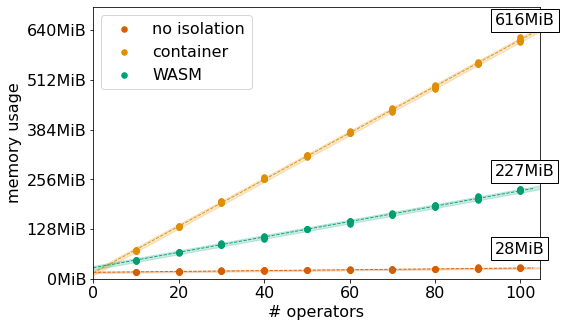

In [23]:
fig, axs = plt.subplots(figsize=fig_size)

col = newCol()
regs = {}
for group_id, group_df in df_active.groupby(["type", "variant"]):
    if group_id[1] != "NONE" or (group_id[0] not in ["comb", "rust", "wasm"]):
        continue

    mean_df = group_df.groupby("dataset")[["workers", "mem_usage"]].quantile(0.95)
    std_df = group_df.groupby("dataset").mem_usage.std()
    std_df.name = "mem_usage_std"
    group_df = pd.concat([mean_df, std_df], axis=1)
    
    opts = dict(
        x="workers",
        y="mem_usage",
        xlim=(0, None),
        ylim=(0, 700*1024*1024 + 1),
        ax=axs,
        c=col(group_id),
        label={
            "comb": "no isolation",
            "rust": "container",
            "wasm": "WASM"
        }[group_id[0]]
    )
    
    group_df.plot(kind="scatter", s=30, **opts)
    
    reg = train_reg(group_df.workers, group_df.mem_usage)
    regs[group_id] = reg
    
    prediction = eval_reg(reg, pd.Series([*np.arange(0, 101, 10), 103]))
    
    prediction.plot(style="--", linewidth=0.9, **opts)
    
    max_mem = prediction[100]
    plt.text(94, max_mem + 30 * MIB, h(max_mem, 2, 0), va='bottom', bbox=dict(facecolor='white'))
    
    x_values = np.arange(0, 110, 1)
    y_values = eval_reg(reg, x_values.reshape(-1, 1))
    y_std = np.array([1.96 * reg.pred_std(x) for x in x_values])

    plt.fill_between(x_values, y_values-y_std, y_values+y_std, alpha=0.2, color=col(group_id))

    """
    plt.errorbar(
        group_df.workers,
        group_df.mem_usage,
        yerr=1.96 * group_df.mem_usage_std,
        fmt=' ',
        capsize=3,
        elinewidth=2,
        capthick=2,
        color=col(group_id),
    )
    """

axs.set_ylabel("memory usage")
axs.set_xlabel("# operators")

memory_y_axis(axs)

plt.savefig('./images/03_dynamic_active.png', bbox_inches='tight')

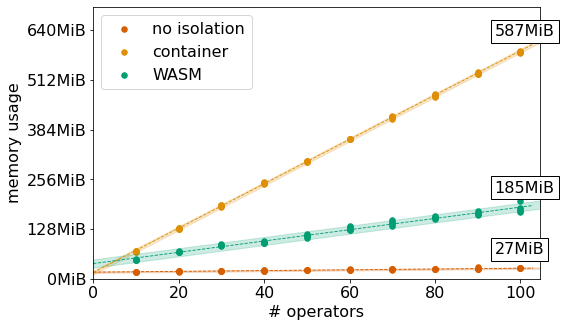

In [24]:
_, axs = plt.subplots(figsize=fig_size)

col = newCol()
regs = {}
for group_id, group_df in df_idle.groupby(["type", "variant"]):
    if group_id[1] != "NONE" or (group_id[0] not in ["comb", "rust", "wasm"]):
        continue

    mean_df = group_df.groupby("dataset")[["workers", "mem_usage"]].quantile(0.95)
    std_df = group_df.groupby("dataset").mem_usage.std()
    std_df.name = "mem_usage_std"
    group_df = pd.concat([mean_df, std_df], axis=1)
    
    opts = dict(
        x="workers",
        y="mem_usage",
        xlim=(0, None),
        ylim=(0, 700*1024*1024 + 1),
        ax=axs,
        c=col(group_id),
        label={
            "comb": "no isolation",
            "rust": "container",
            "wasm": "WASM"
        }[group_id[0]]
    )
    
    group_df.plot(kind="scatter", s=30, **opts)
    
    reg = train_reg(group_df.workers, group_df.mem_usage)
    regs[group_id] = reg
    
    prediction = eval_reg(reg, pd.Series([*np.arange(0, 101, 10), 103]))
    
    prediction.plot(style="--", linewidth=0.9, **opts)
    
    max_mem = prediction[100]
    plt.text(94, max_mem + 30 * MIB, h(max_mem, 2, 0), va='bottom', bbox=dict(facecolor='white'))
    
    x_values = np.arange(0, 110, 1)
    y_values = eval_reg(reg, x_values.reshape(-1, 1))
    y_std = np.array([1.96 * reg.pred_std(x) for x in x_values])

    plt.fill_between(x_values, y_values-y_std, y_values+y_std, alpha=0.2, color=col(group_id))
    
    """
    plt.errorbar(
        group_df.workers,
        group_df.mem_usage,
        yerr=1.96 * group_df.mem_usage_std,
        fmt=' ',
        capsize=3,
        elinewidth=2,
        capthick=2,
        color=col(group_id),
    )
    """

axs.set_ylabel("memory usage")
axs.set_xlabel("# operators")
memory_y_axis(axs)

plt.savefig('./images/03_dynamic_idle.png', bbox_inches='tight')

unins vs wasm (increase): 80.49\% \pm8.65\%


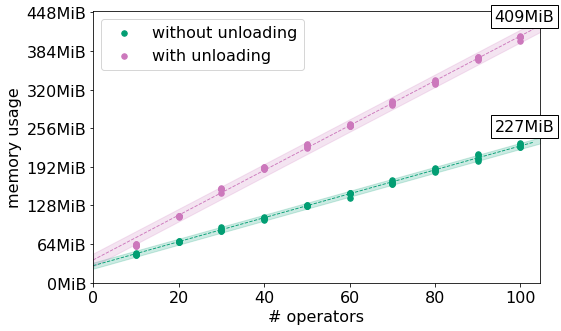

In [25]:
fig, axs = plt.subplots(figsize=fig_size)

col = newCol()
maxs = {}
for group_id, group_df in df_active.groupby(["type", "variant"]):
    if group_id[0] != "wasm":
        continue

    mean_df = group_df.groupby("dataset")[["workers", "mem_usage"]].quantile(0.95)
    std_df = group_df.groupby("dataset").mem_usage.std()
    std_df.name = "mem_usage_std"
    group_df = pd.concat([mean_df, std_df], axis=1)
    
    opts = dict(
        x="workers",
        y="mem_usage",
        xlim=(0, None),
        ylim=(0, 450*1024*1024 + 1),
        ax=axs,
        c=col(group_id),
        label=(((group_id[1] == "NONE") and "without unloading") or "with unloading")
    )
    
    group_df.plot(kind="scatter", s=30, **opts)
    
    reg = train_reg(group_df.workers, group_df.mem_usage)
    
    prediction = eval_reg(reg, pd.Series([*np.arange(0, 101, 10), 103]))
    
    prediction.plot(style="--", linewidth=0.9, **opts)
    
    max_mem = prediction[100]
    plt.text(94, max_mem + 20 * MIB, h(max_mem, 2, 0), va='bottom', bbox=dict(facecolor='white'))
    maxs[group_id] = (max_mem - 1.96 * reg.pred_std(100), max_mem + 1.96 * reg.pred_std(100))
    
    x_values = np.arange(0, 110, 1)
    y_values = eval_reg(reg, x_values.reshape(-1, 1))
    y_std = np.array([1.96 * reg.pred_std(x) for x in x_values])

    plt.fill_between(x_values, y_values-y_std, y_values+y_std, alpha=0.2, color=col(group_id))

    """
    plt.errorbar(
        group_df.workers,
        group_df.mem_usage,
        yerr=1.96 * group_df.mem_usage_std,
        fmt=' ',
        capsize=3,
        elinewidth=2,
        capthick=2,
        color=col(group_id),
    )
    """

axs.set_ylabel("memory usage")
axs.set_xlabel("# operators")
memory_y_axis(axs)

plt.savefig('./images/04_wasm_unloading_active.png', bbox_inches='tight')

print("unins vs wasm (increase): " + compare_maxes(maxs, ('wasm', 'unins'), ('wasm', 'NONE'), increase=True))

unins vs wasm (decrease): 52.66\% \pm14.23\%


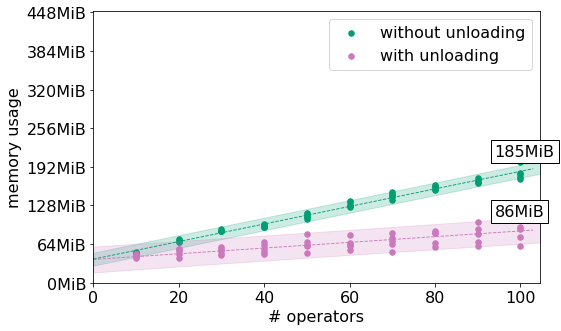

In [26]:
fig, axs = plt.subplots(figsize=fig_size)

col = newCol()
regs = {}
maxs = {}
for group_id, group_df in df_idle.groupby(["type", "variant"]):
    if group_id[0] != "wasm":
        continue

    mean_df = group_df.groupby("dataset")[["workers", "mem_usage"]].quantile(0.95)
    std_df = group_df.groupby("dataset").mem_usage.std()
    std_df.name = "mem_usage_std"
    group_df = pd.concat([mean_df, std_df], axis=1)
    
    opts = dict(
        x="workers",
        y="mem_usage",
        xlim=(0, None),
        ylim=(0, 450*1024*1024 + 1),
        ax=axs,
        c=col(group_id),
        label=(((group_id[1] == "NONE") and "without unloading") or "with unloading")
    )
    
    group_df.plot(kind="scatter", s=30, **opts)
    
    reg = train_reg(group_df.workers, group_df.mem_usage)
    regs[group_id] = reg
    
    prediction = eval_reg(reg, pd.Series([*np.arange(0, 101, 10), 103]))
    
    prediction.plot(style="--", linewidth=0.9, **opts)
    
    max_mem = prediction[100]
    plt.text(94, max_mem + 20 * MIB, h(max_mem, 2, 0), va='bottom', bbox=dict(facecolor='white'))
    maxs[group_id] = (max_mem - 1.96 * reg.pred_std(100), max_mem + 1.96 * reg.pred_std(100))
    
    x_values = np.arange(0, 110, 1)
    y_values = eval_reg(reg, x_values.reshape(-1, 1))
    y_std = np.array([1.96 * reg.pred_std(x) for x in x_values])

    plt.fill_between(x_values, y_values-y_std, y_values+y_std, alpha=0.2, color=col(group_id))

    """
    plt.errorbar(
        group_df.workers,
        group_df.mem_usage,
        yerr=1.96 * group_df.mem_usage_std,
        fmt=' ',
        capsize=3,
        elinewidth=2,
        capthick=2,
        color=col(group_id),
    )
    """

axs.set_ylabel("memory usage")
axs.set_xlabel("# operators")
memory_y_axis(axs)

plt.savefig('./images/04_wasm_unloading_idle.png', bbox_inches='tight')

print("unins vs wasm (decrease): " + compare_maxes(maxs, ('wasm', 'unins'), ('wasm', 'NONE'), increase=False))

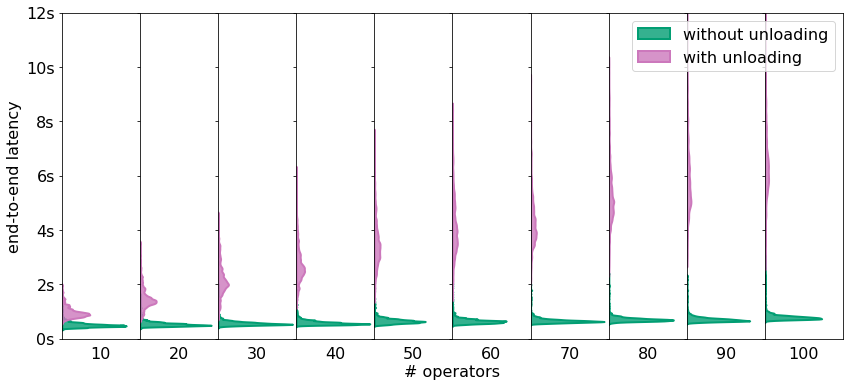

In [27]:
fig, axs = plt.subplots(1, 10, figsize=(14,6), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0)

col = newCol()
for group_id, group_df in df_time.groupby(["workers", "type", "variant"]):
    if group_id[1] != "wasm":
        continue

    index = int(group_id[0] / 10 - 1)

    sns.kdeplot(
        data=group_df,
        y="roundtime",
        legend=False,
        ax=axs[index],
        fill=True,
        alpha=0.8,
        linewidth=2,
        bw_adjust=0.3,
        color=col((group_id[1], group_id[2]))
    )

plt.gca().legend(("without unloading", "with unloading"))

index = 0
for ax in axs:
    ax.axes.set_xticks([])
    ax.axes.set_ylim(0, 12000)
    ax.axes.set_xlabel((1+index)*10)
    index+=1
    
axs[0].axes.set_ylabel("end-to-end latency")
mseconds_y_axis(axs[0], precision=0)

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("# operators")

plt.savefig('./images/04_wasm_unloading_e2e_hist.png', bbox_inches='tight')

In [28]:
ERROR_BAR_DEFAULTS = dict(
    fmt=" ",
    capsize=3,
    elinewidth=2,
    capthick=2,
)

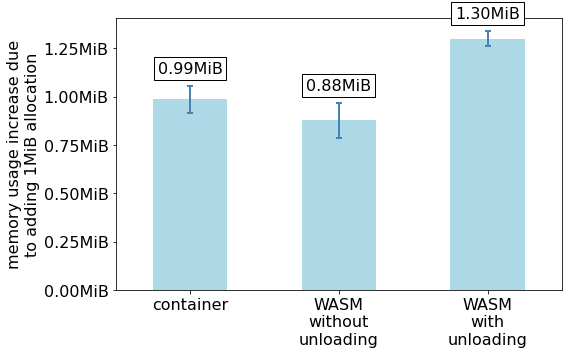

In [29]:
fig, axs = plt.subplots(figsize=fig_size)

scale = {}
i = 0
for group_id, group_df in df_heap_active[df_heap_active.workers == 60].groupby(["type", "variant"]):
    mean_df = group_df.groupby("dataset")[["heap_mem", "mem_usage"]].quantile(0.95)
    std_df = group_df.groupby("dataset").mem_usage.std()
    std_df.name = "mem_usage_std"
    group_df = pd.concat([mean_df, std_df], axis=1)
    
    MIB = 1024*1024
    
    reg = train_reg(group_df.heap_mem / MIB, group_df.mem_usage)
    
    mem = (eval_reg(reg, 1) - eval_reg(reg, 0)) / 60
    mem_std = 1.96 * (reg.slope_std / 60)
    scale[group_id] = {
        "mem": mem,
        "mem_std": mem_std
    }
    
    plt.text(i, mem + mem_std + MIB / 20, h(mem, 2), ha='center', va='bottom', bbox=dict(facecolor='white'))
    i += 1
    
df = pd.DataFrame(scale.values(), index=scale.keys())
df = df.rename({"golang":0, "rust":1, "wasm":2, "comb":3})
df = df.sort_index()

ax = df.plot.bar(y="mem", color=["lightblue"], ax=axs, legend=False)
plt.errorbar(
    np.arange(len(df)),
    df.mem,
    yerr=df.mem_std,
    ecolor="steelblue",
    **ERROR_BAR_DEFAULTS
)

ax.set_ylabel("memory usage increase due\nto adding 1MiB allocation")
memory_y_axis(ax, 2, 2)

locs, labels = plt.xticks()
new_labels = [{
    "(3, NONE)": "rust\ncombined",
    "(0, NONE)": "golang",
    "(1, NONE)": "container",
    "(2, NONE)": "WASM\nwithout\nunloading",
    "(2, unins)": "WASM\nwith\nunloading",
}[x.get_text()] for x in labels]
plt.xticks(locs, new_labels, rotation=0)

plt.savefig('./images/05_heap_active.png', bbox_inches='tight')

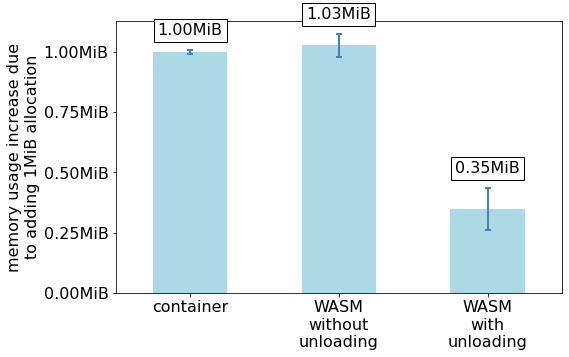

In [30]:
fig, axs = plt.subplots(figsize=fig_size)

scale = {}
i = 0
for group_id, group_df in df_heap_idle[df_heap_idle.workers == 60].groupby(["type", "variant"]):
    mean_df = group_df.groupby("dataset")[["heap_mem", "mem_usage"]].quantile(0.95)
    std_df = group_df.groupby("dataset").mem_usage.std()
    std_df.name = "mem_usage_std"
    group_df = pd.concat([mean_df, std_df], axis=1)
    
    MIB = 1024*1024
    
    reg = train_reg(group_df.heap_mem / MIB, group_df.mem_usage)
    
    mem = (eval_reg(reg, 1) - eval_reg(reg, 0)) / 60
    mem_std = 1.96 * (reg.slope_std / 60)
    scale[group_id] = {
        "mem": mem,
        "mem_std": mem_std
    }
    
    plt.text(i, mem + mem_std + MIB / 20, h(mem, 2), ha='center', va='bottom', bbox=dict(facecolor='white'))
    i += 1

df = pd.DataFrame(scale.values(), index=scale.keys())
df = df.rename({"golang":0, "rust":1, "wasm":2, "comb":3})
df = df.sort_index()

ax = df.plot.bar(y="mem", color=["lightblue"], ax=axs, legend=False)
plt.errorbar(
    np.arange(len(df)),
    df.mem,
    yerr=df.mem_std,
    ecolor="steelblue",
    **ERROR_BAR_DEFAULTS
)

ax.set_ylabel("memory usage increase due\nto adding 1MiB allocation")
memory_y_axis(ax, 2, 2)

locs, labels = plt.xticks()
new_labels = [{
    "(3, NONE)": "rust\ncombined",
    "(0, NONE)": "golang",
    "(1, NONE)": "container",
    "(2, NONE)": "WASM\nwithout\nunloading",
    "(2, unins)": "WASM\nwith\nunloading",
}[x.get_text()] for x in labels]
plt.xticks(locs, new_labels, rotation=0)

plt.savefig('./images/05_heap_idle.png', bbox_inches='tight')

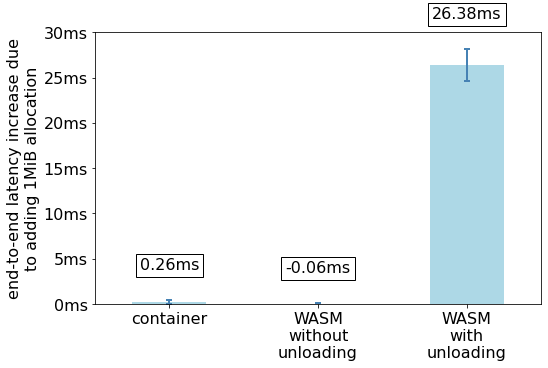

In [31]:
fig, axs = plt.subplots(figsize=fig_size)

scale = {}
i = 0
for group_id, group_df in df_heap_time[df_heap_time.workers == 60].groupby(["type", "variant"]):
    mean_df = group_df.groupby("dataset")[["heap_mem", "roundtime"]].mean()
    std_df = group_df.groupby("dataset").roundtime.std()
    std_df.name = "mem_usage_std"
    group_df = pd.concat([mean_df, std_df], axis=1)
    
    MIB = 1024*1024
    
    reg = train_reg(group_df.heap_mem / MIB, group_df.roundtime)
    
    roundtrip = (eval_reg(reg, 1) - eval_reg(reg, 0)) / 60
    roundtrip_std = 1.96 * (reg.slope_std / 60)
    scale[group_id] = {
        "roundtrip": roundtrip,
        "roundtrip_std": roundtrip_std
    }
    
    plt.text(i, roundtrip + roundtrip_std + 3, hs(roundtrip, 0), ha='center', va='bottom', bbox=dict(facecolor='white'))
    i += 1

df = pd.DataFrame(scale.values(), index=scale.keys())
df = df.rename({"golang":0, "rust":1, "wasm":2, "comb":3})
df = df.sort_index()

ax = df.plot.bar(y="roundtrip", color=["lightblue"], ax=axs, ylim=(0, 30), legend=False)
plt.errorbar(
    np.arange(len(df)),
    df.roundtrip,
    yerr=df.roundtrip_std,
    ecolor="steelblue",
    **ERROR_BAR_DEFAULTS
)

ax.set_ylabel("end-to-end latency increase due\nto adding 1MiB allocation")
mseconds_y_axis(ax, 0, 0)

locs, labels = plt.xticks()
new_labels = [{
    "(3, NONE)": "rust\ncombined",
    "(0, NONE)": "golang",
    "(1, NONE)": "container",
    "(2, NONE)": "WASM\nwithout\nunloading",
    "(2, unins)": "WASM\nwith\nunloading",
}[x.get_text()] for x in labels]
plt.xticks(locs, new_labels, rotation=0)

plt.savefig('./images/05_heap_e2e.png', bbox_inches='tight')

In [32]:
[h(x) for x in df_heap_idle.heap_mem.unique()]

['0.00B', '1.00MiB', '2.00MiB', '3.00MiB']